In [1]:
savefig = False

## Notes:
- 20 has the best NSE
- opt 26 has improved the NSE to 0.363; however, the tail is fat, likely because of the gw model. Specifically, because gw2 ~1, all of the GW reservoir is released into the stream.
- opt 27 attempting an optimization with gw2 = 0
- opt 27 didn't work out that well, converged very quickly, but with an unrealistic hydrograph
- opt 28 - re-do opt 26 with a wider parameter space for gw1 and gw2
- opt 29 - re-do opt 28 with the snow parameters to improve timing
- opt 30 - calibration without gw2 and with all the other calibration parameters, soil depth was also increased to 50 m
- opt 31 - same as above, but soil depth is now also calibrated.
- opt 32 - add a loss term to the calibration...

- opt 37 (output is labeled 36) rooting depth constrained to literature

### Sensitivity Anaylsis:

Using opt 26 to construct dotty plots, it appears that the objective function score is really only sensitive to gw1, gw2, and po

In [2]:
opt = '40'

In [3]:
from hydro import objective_fxns as obfx
import datetime

In [4]:
fl = './Como_SCEUA_%s.out'%opt

In [5]:
with open(fl) as f:
    dat = f.readlines()
    
dat = [x.strip() for x in dat] # remove whitespace

In [6]:
times = []
key = 'time cost'
for l in dat:
    if len(l) < len(key):
        exit
    
    if l[:len(key)] == key:
        tag,val = l.split('=')
        
    else:
        continue
    
    times.append(float(val.split(' ')[1]))

times = np.array(times)

In [7]:
times /= 60.

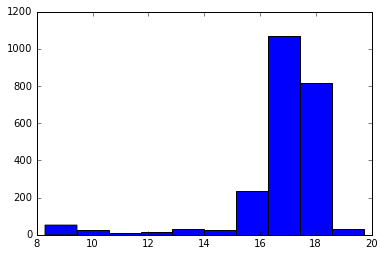

In [8]:
plt.hist(times);

In [9]:
len(times)

2310

In [10]:
tmp = pd.read_csv('./Como_SCEUA_%s.csv'%(opt))

In [11]:
len(tmp)

1651

In [12]:
tmp.sort_values(by = 'like1',ascending=False).iloc[1:6,0:17]

,like1,pargw1,pargw2,parsd,parm,parksat,parcrd,partrd,parpo,parpa,parsnowtemp,parraintemp,parsmtc,parmsed,para,parb,parc
1365,-0.693076,0.431707,0.168340,0.601265,24.052533,122.731664,0.577681,0.033624,3.570694,804.935265,3.032986,-2.561700,0.176698,-78.335363,0.115062,20.122044,0.623436
3,-0.729113,0.332524,0.005451,1.509656,20.025146,158.754823,1.765613,0.396077,0.594764,317.917021,0.273628,-1.066652,0.254228,-46.217417,6.272412,22.012469,0.626705
856,-0.741188,0.138902,0.486267,1.881759,4.706205,317.027331,1.694616,0.146532,2.649358,748.433366,0.861861,-3.668324,0.285071,-91.213109,1.294819,13.430063,0.588600
1510,-0.757659,0.630411,0.301106,1.290054,19.729513,164.506709,1.462568,0.242865,3.191566,333.442161,2.392041,-1.720153,0.473557,-54.161267,3.998156,17.769975,0.544398
1461,-0.778466,0.665324,0.250248,1.183473,11.265328,406.725340,1.057533,0.377564,3.182238,325.914025,1.281924,-2.493429,0.284460,-63.890017,8.986835,11.338208,0.575429


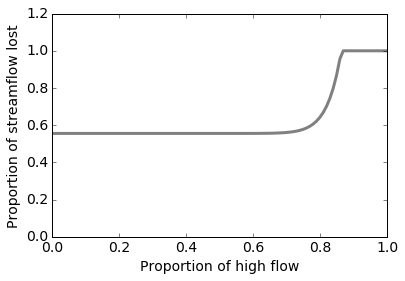

In [13]:
# define a function that increases the leakage as flow increases
def leakage(x,a,b,c): 
    y = a*(x**b) + c
    y[y>1.] = 1
    
    return y



x = np.linspace(0,1,100,endpoint=True)
y = leakage(x,10.204982,21.230562,0.555779)

plt.plot(x,y,'-',c='0.5',lw=3)
plt.xlabel('Proportion of high flow', fontsize = 14)
plt.ylabel('Proportion of streamflow lost',fontsize = 14)
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
plt.ylim(0,1.2)
if savefig: plt.savefig('./figures/optimized_leakage_curve.png',bbox_inches='tight',dpi=300)
if savefig: plt.savefig('./figures/optimized_leakage_curve.pdf',bbox_inches='tight')

In [14]:
obs = pd.read_pickle('/RHESSys/Como/obs/como_q_obs.pcl')['2004-10-01':'2007-09-30']
obs = obs.discharge.as_matrix()

In [15]:
nses = []
for i in np.arange(0,len(tmp)):
    simtmp = tmp.iloc[i,17:-1].as_matrix()
    nses.append(obfx.nashsut(obs,simtmp))

In [16]:
round(np.max(nses),2)

0.73

In [17]:
round(np.min(nses),2)

-8.41

In [18]:
sim = tmp.sort_values(by = 'like1',ascending=False).iloc[1,17:-1].as_matrix()
#print len(obs)
#print len(sim)
#4
#9

In [19]:
nse = obfx.nashsut(obs,sim)
print 'NSE: %s'%round(nse,3)

NSE: 0.734


In [20]:
tmp.sort_values(by = 'like1',ascending=False,inplace=True)

In [21]:
# fill a data frame with the top twenty
sims = pd.DataFrame()
for i in range(20):
    sims['sim_%i'%i] = tmp.iloc[i,17:-1].as_matrix()

sims.index = pd.DatetimeIndex(pd.date_range(start='2004-10-01',periods=len(sim),freq='D'))
sims['idx'] = np.arange(0,len(sims))

In [22]:
sims = pd.melt(sims,id_vars='idx')

In [23]:
dat = pd.DataFrame()
dat['Observations'] = obs
dat['Simulation'] = sim
dat['Sim_min'] = sims.groupby(by='idx').min()['value']
dat['Sim_max'] = sims.groupby(by='idx').max()['value']
dat.index = pd.DatetimeIndex(pd.date_range(start='2004-10-01',periods=len(sim),freq='D'))

In [24]:
savefig = True

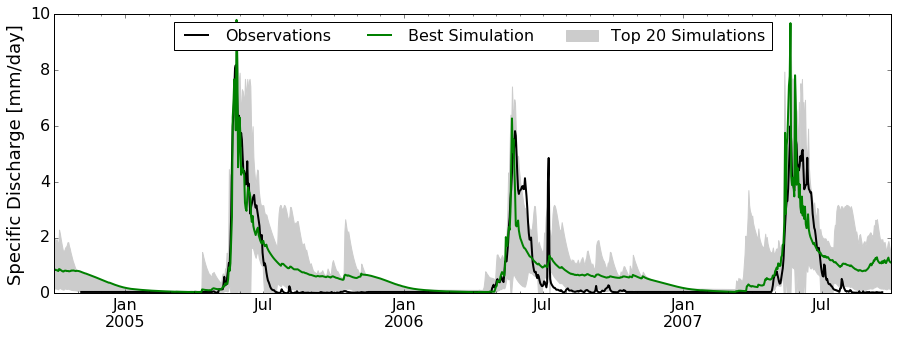

In [26]:
#plt.figure(figsize=(15,5))
dat['Observations'].plot(figsize=(15,5),color='k',lw=2,label='Observations')
dat['Simulation'].plot(figsize=(15,5),color='g',lw=2,label='Best Simulation')
plt.fill_between(dat.index,dat.Sim_min,dat.Sim_max,facecolor='0.8',edgecolor='0.8',zorder=1,color='0.8',label='Top 20 Simulations')
plt.ylim(0,10)
plt.legend(fontsize=16,ncol=3,loc='upper center')
plt.ylabel('Specific Discharge [mm/day]', fontsize = 18)
ax = plt.gca()
#plt.title('Como Creek, Training Period NSE: %s'%(round(nse,3)), fontsize = 20)
[tick.label.set_fontsize(16) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(16) for tick in ax.xaxis.get_minor_ticks()];
[tick.label.set_fontsize(16) for tick in ax.yaxis.get_major_ticks()];
if savefig: plt.savefig('./figures/experiment_calibration_%s.png'%(opt),dpi=300,bbox_inches='tight')
if savefig: plt.savefig('./figures/experiment_calibration_%s.pdf'%(opt),bbox_inches='tight')
savefig = False

## Sensitivity Dotty Plots - from Opt. 26

In [ ]:
def dotty_plot(par,label):
    labelsize = 16
    tmp.plot.scatter('like1',par,figsize=(10,5))
    plt.ylabel(label, fontsize=labelsize)
    plt.xlabel('Likelihood', fontsize=labelsize)
    ax = plt.gca()
    [tick.label.set_fontsize(labelsize-2) for tick in ax.xaxis.get_major_ticks()];
    [tick.label.set_fontsize(labelsize-2) for tick in ax.yaxis.get_major_ticks()];
    plt.xlim(-2,-1)

In [ ]:
dotty_plot('pargw1','gw1')
dotty_plot('pargw2','gw2')
dotty_plot('parpo','po')

In [ ]:
dotty_plot('pargw1','gw1')
dotty_plot('pargw2','gw2')
dotty_plot('parm','m')
dotty_plot('parksat','ksat')
dotty_plot('partrd','trd')
dotty_plot('parcrd','crd')
dotty_plot('parpo','po')
dotty_plot('parpa','pa')

In [ ]:
tmp.plot.scatter('like1','parksat',figsize=(10,5))
plt.xlim(-2,-1)

In [ ]:
tmp.plot.scatter('like1','parcrd',figsize=(10,5))
plt.xlim(-2,-1)

In [ ]:
tmp.plot.scatter('like1','partrd',figsize=(10,5))
plt.xlim(-2,-1)

In [ ]:
tmp.plot.scatter('like1','parpo',figsize=(10,5))
plt.xlim(-2,-1)

In [ ]:
tmp.plot.scatter('like1','parpa',figsize=(10,5))
plt.xlim(-2,-1)